In [1]:
%run setup.ipynb

In [2]:
tbl_neaf = (etl
    .fromtsv('../data/Neafsey_top_MS_allele_freqs.2.txt')       
    .pushheader(['ID', 'chrom', 'pos', 'allele1', 'allele2', 'af_gamb', 'af_colu', 'af_bama'])
    .convert('pos', int)
    .convert((5, 6, 7), float)
    .addfield('allele_gamb', lambda row: row.allele1 if row.af_gamb > row.af_colu else row.allele2)
    .addfield('allele_colu', lambda row: row.allele1 if row.af_gamb < row.af_colu else row.allele2)
)
tbl_neaf

0|ID,1|chrom,2|pos,3|allele1,4|allele2,5|af_gamb,6|af_colu,7|af_bama,8|allele_gamb,9|allele_colu
rs180290715,2L,181564,A,G,0.0294117647058823,1.0,0.970588235294118,G,A
rs180290738,2L,210286,T,G,0.972222188888876,0.0,0.972222188888876,T,G
rs180290751,2L,356421,T,C,1.0,0.0,1.0,T,C
rs180290761,2L,441325,A,C,0.0,1.0,1.0,C,A
rs180290764,2L,456831,T,G,1.0,0.0,1.0,T,G


In [4]:
chrom = 'X'

In [5]:
callset_pass_biallelic = zarr.open_group('../phase2.AR1/variation/main/zarr2/ag1000g.phase2.ar1.pass.biallelic', mode='a')
callset_pass_biallelic

<zarr.hierarchy.Group '/'>

In [6]:
# load Ag1000G SNP positions
pos = allel.SortedIndex(callset_pass_biallelic[chrom]['variants/POS'])
pos

0,1,2,3,4,...,4472260,4472261,4472262,4472263,4472264
49,56,66,80,110,...,24316797,24316800,24316805,24334901,24334916


In [7]:
# extract Neafsey SNP positions
pos_neaf = tbl_neaf.eq('chrom', chrom).values('pos').array()

In [8]:
def compute_aim_gn(chrom):
    
    # extract Neafsey SNP positions
    pos_neaf = tbl_neaf.eq('chrom', chrom).values('pos').array()
    
    # load Ag1000G SNP positions
    pos = allel.SortedIndex(callset_pass_biallelic[chrom]['variants/POS'])
    
    # locate intersection
    loc1, loc2 = pos.locate_intersection(pos_neaf)
    
    # find positions of SNPs in intersection
    pos_isec = pos[loc1]
    
    # subselect SNP tables
    tbl_neaf_isec = tbl_neaf.selectin('pos', pos_isec)
    
#     callset_fn = '../../../data/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/hdf5/biallelic/ag1000g.phase2.ar1.pass.biallelic.h5'
#     callset = zarr.(callset_fn, mode='r')
    vtbl_isec = allel.VariantChunkedTable(callset_pass_biallelic[chrom]['variants'], names=('CHROM', 'POS', 'REF', 'ALT'))
    vtbl_isec = vtbl_isec.compress(loc1)
    # create allele mapping
    ref = vtbl_isec.REF
    alt = vtbl_isec.ALT
    alleles = np.column_stack([tbl_neaf_isec.values('allele_gamb').array(),
                               tbl_neaf_isec.values('allele_colu').array()])
    alleles = alleles[:].astype('|S1')
    mapping = allel.create_allele_mapping(ref, alt, alleles)
    
    # load genotypes
    genotype_isec = allel.GenotypeChunkedArray(callset_pass_biallelic[chrom]['calldata/genotype'])
    genotype_isec = genotype_isec.compress(loc1)
    
    # map alleles 
    genotype_aim = genotype_isec.map_alleles(mapping)
    gn_aim = genotype_aim.to_n_alt()
    
    return gn_aim, pos_isec

In [10]:
gn_aim, pos_isec = compute_aim_gn('X')

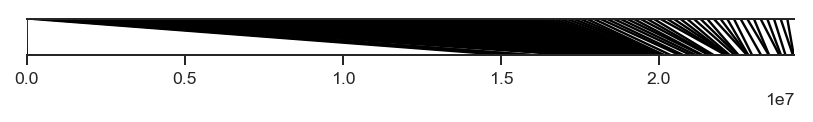

In [13]:
allel.plot_variant_locator(pos_isec, ax=None, start=0, line_kwargs=dict(color='k'));

In [14]:
gn_aim, pos_isec = compute_aim_gn('2L')

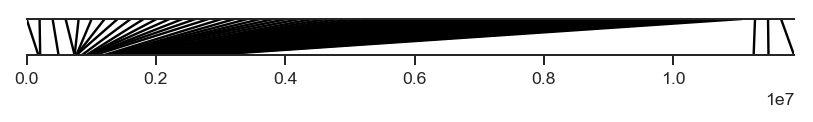

In [16]:
allel.plot_variant_locator(pos_isec, step= 1, ax=None, start=0, line_kwargs=dict(color='k'));

In [17]:
gn_rot = np.rot90(np.asarray(gn_aim))

In [18]:
gn_rot

array([[2, 2, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 1]], dtype=int8)

In [19]:
import matplotlib.colors as c

In [20]:
list(phase2_ar1.genome_agamp3.keys())

['UNKN chromosome:AgamP3:UNKN:1:42389979:1',
 '3R chromosome:AgamP3:3R:1:53200684:1',
 '3L chromosome:AgamP3:3L:1:41963435:1',
 '2R chromosome:AgamP3:2R:1:61545105:1',
 '2L chromosome:AgamP3:2L:1:49364325:1',
 'Y_unplaced chromosome:AgamP3:Y_unplaced:1:237045:1',
 'X chromosome:AgamP3:X:1:24393108:1']

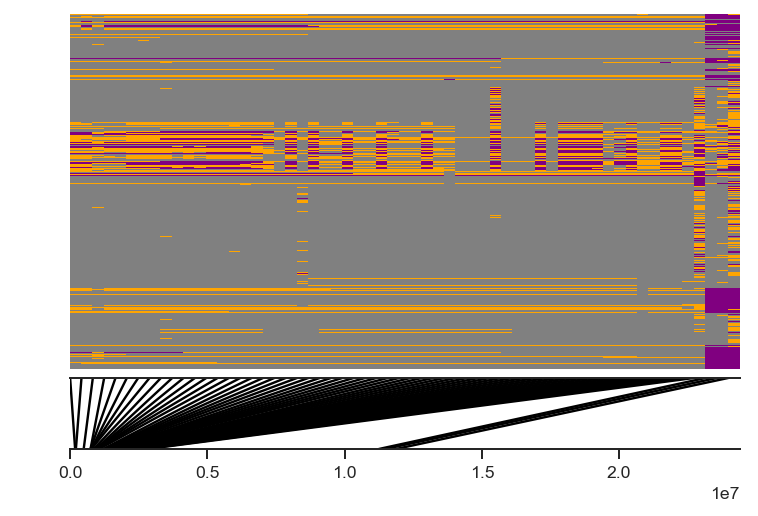

In [21]:
fig = plt.figure()

# define subplot layout
gs_nrows = 2
gs_ncols = 1
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04, height_ratios=[2.5, .5])

ax = fig.add_subplot(gs[0, 0])
grr = gn_rot
cMap = c.ListedColormap(['gray',  'orange', 'purple'])
ax.pcolormesh(grr, cmap = cMap)
y_max = grr.shape[0]
ax.set_ylim(0, y_max)
x_max = grr.shape[1]
ax.set_xlim(0, x_max)
ax.axis('off')
#counter += 1

ax = fig.add_subplot(gs[1,0])
stop = len(phase2_ar1.genome_agamp3['X chromosome:AgamP3:X:1:24393108:1']) + 1
allel.plot_variant_locator(pos_isec, ax=ax, start=0, step=1, stop=stop, line_kwargs=dict(color='k'));

In [22]:
counter = {
    'AOcol' : 0,
    'BFcol' : 1,
    'CIcol' : 2,
    'GHcol' : 3,
    'GNcol'  :4,
    'GW' : 5,
    'GM' : 6,
    'GNgam' : 7,
    'GHgam' : 8,
    'GQgam' : 9,
    'BFgam' : 10,
    'CMgam' : 11,
    'UGgam' : 12,
    'GAgam' : 13,
    'FRgam' : 14,
    'KE' : 15
}

In [23]:
#make a subpop dictionary
df_samples = pd.read_csv('../phase2.AR1/samples/samples.meta.txt', delimiter='\t')
samples = list(df_samples['ox_code'])
subpop_ids = sorted(df_samples.population.unique())
subpops = {pid: list(df_samples[df_samples.population == pid].index) for pid in subpop_ids}

In [24]:
list(phase2_ar1.genome_agamp3.keys())

['UNKN chromosome:AgamP3:UNKN:1:42389979:1',
 '3R chromosome:AgamP3:3R:1:53200684:1',
 '3L chromosome:AgamP3:3L:1:41963435:1',
 '2R chromosome:AgamP3:2R:1:61545105:1',
 '2L chromosome:AgamP3:2L:1:49364325:1',
 'Y_unplaced chromosome:AgamP3:Y_unplaced:1:237045:1',
 'X chromosome:AgamP3:X:1:24393108:1']

In [25]:
#make chrom length dictionary
chrom_len = {'UNKN' : 42389979,
            '3R' : 53200684,
            '3L' : 41963435,
            '2R' : 61545105,
            '2L' : 49364325,
            'Y_unplaced' : 237045,
            'X' : 24393108}

In [26]:
def chrom_aim(chrom):

    gn_aim, pos_isec = compute_aim_gn(chrom)

    fig = plt.figure(figsize=(8,10))

    # define subplot layout
    gs_nrows = 17
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04, height_ratios=[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])

    for p in list(counter.keys()):
        gr = gn_aim.take(subpops[p], axis=1)
        grr = np.rot90(gr)
        
#         b = totes_col.take(subpops[p])
#         ind = np.argsort(b)
#         grr = np.take(grrr, ind, axis=0)
        
        ax = fig.add_subplot(gs[counter[p], 0])


        cMap = c.ListedColormap(['gray',  'orange', 'purple'])
        ax.pcolormesh(grr, cmap = cMap)
        y_max = grr.shape[0]
        ax.set_ylim(0, y_max)
        x_max = grr.shape[1]
        ax.set_xlim(0, x_max)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(p)
            

    ax = fig.add_subplot(gs[16,0])
    stop = chrom_len[chrom] + 1
    allel.plot_variant_locator(pos_isec, ax=ax, step=1, start=0, stop=stop, line_kwargs=dict(color='k'))
    plt.xlabel(chrom);
    
#     return gr, grr, grrr

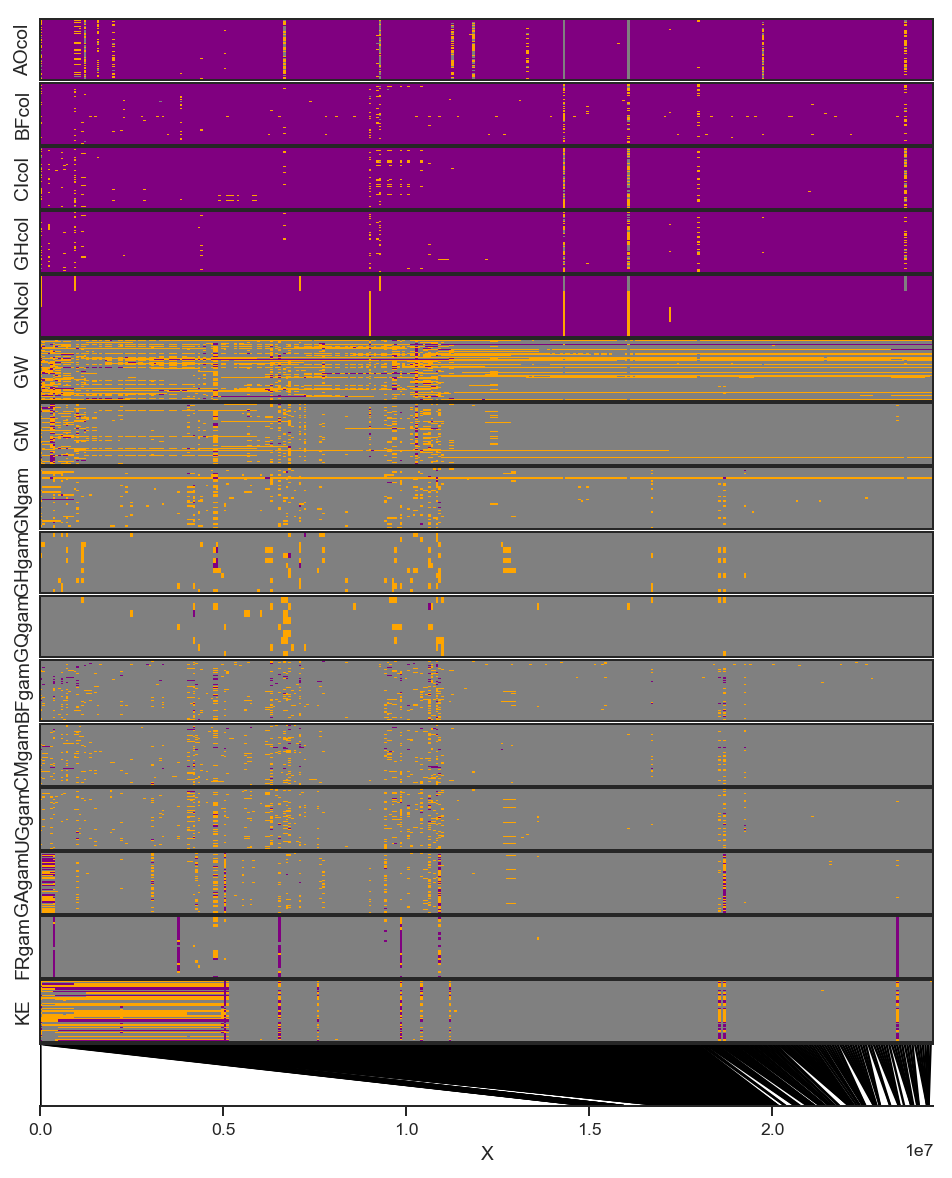

In [27]:
chrom_aim('X')

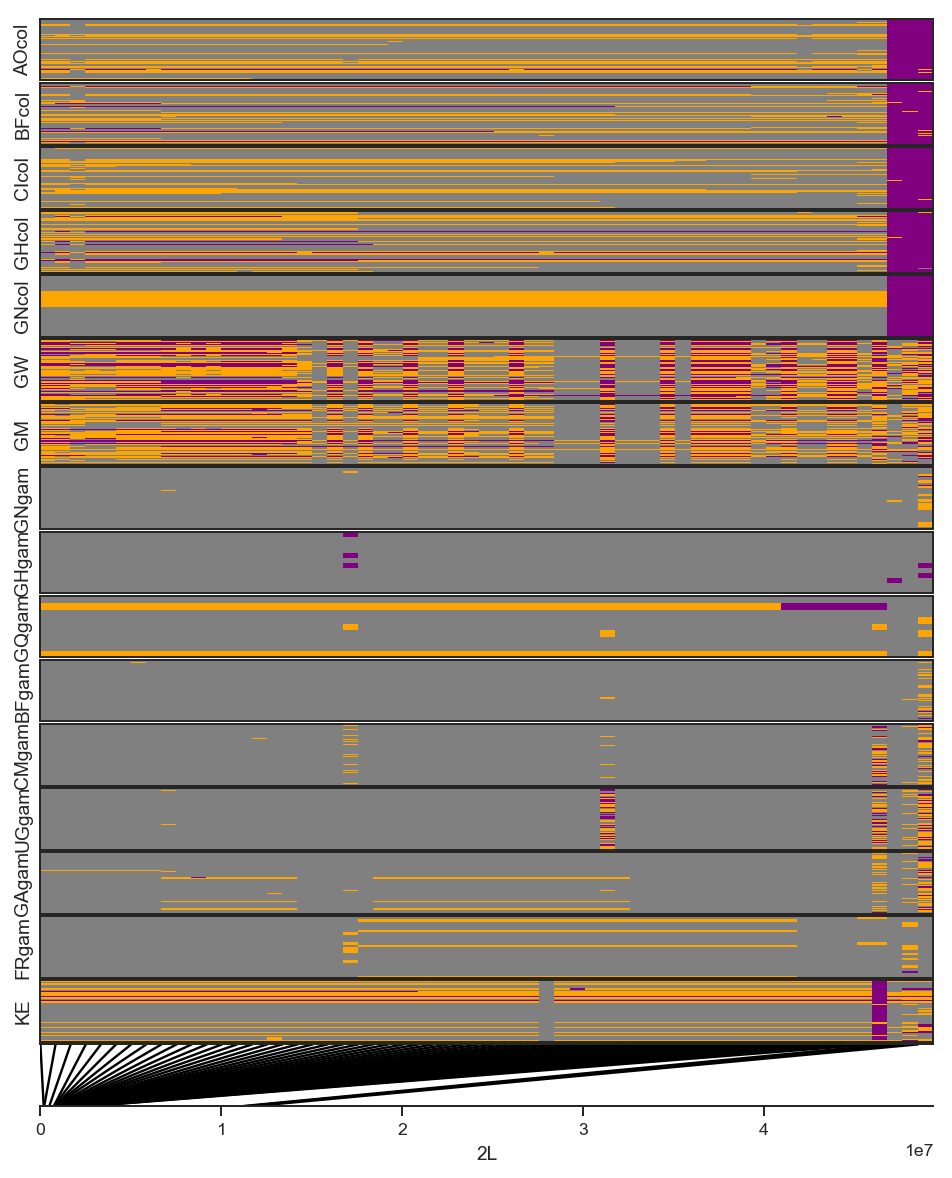

In [28]:
chrom_aim('2L')

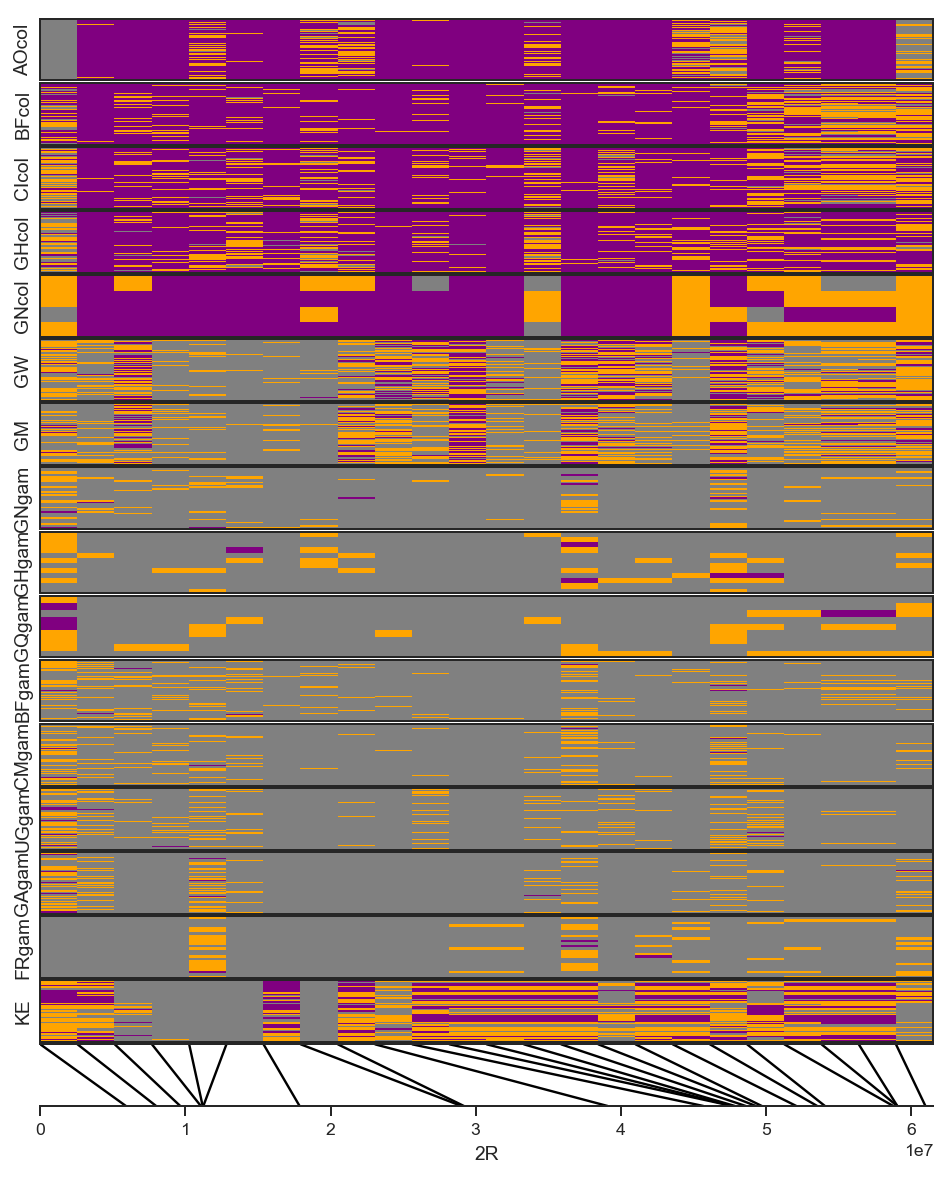

In [29]:
chrom_aim('2R')

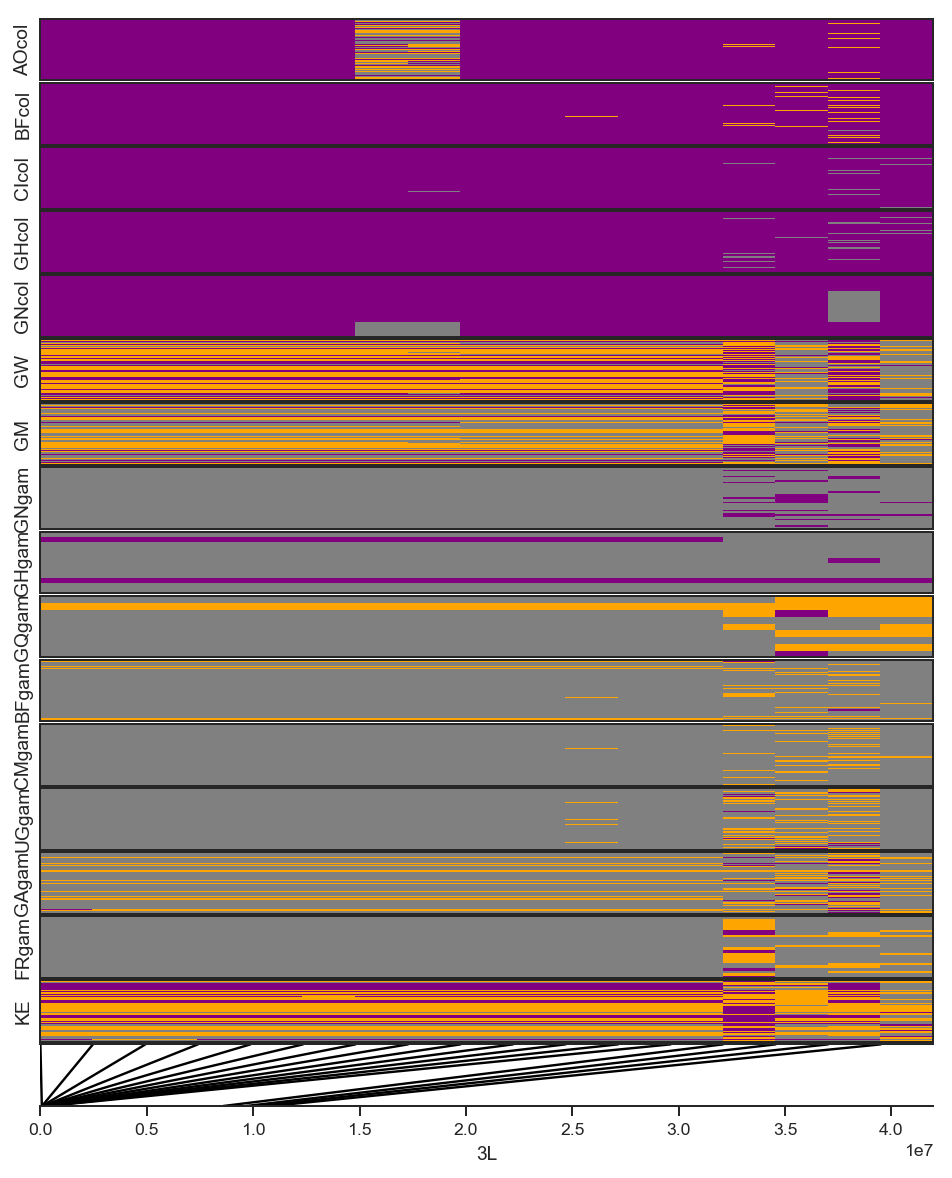

In [30]:
chrom_aim('3L')

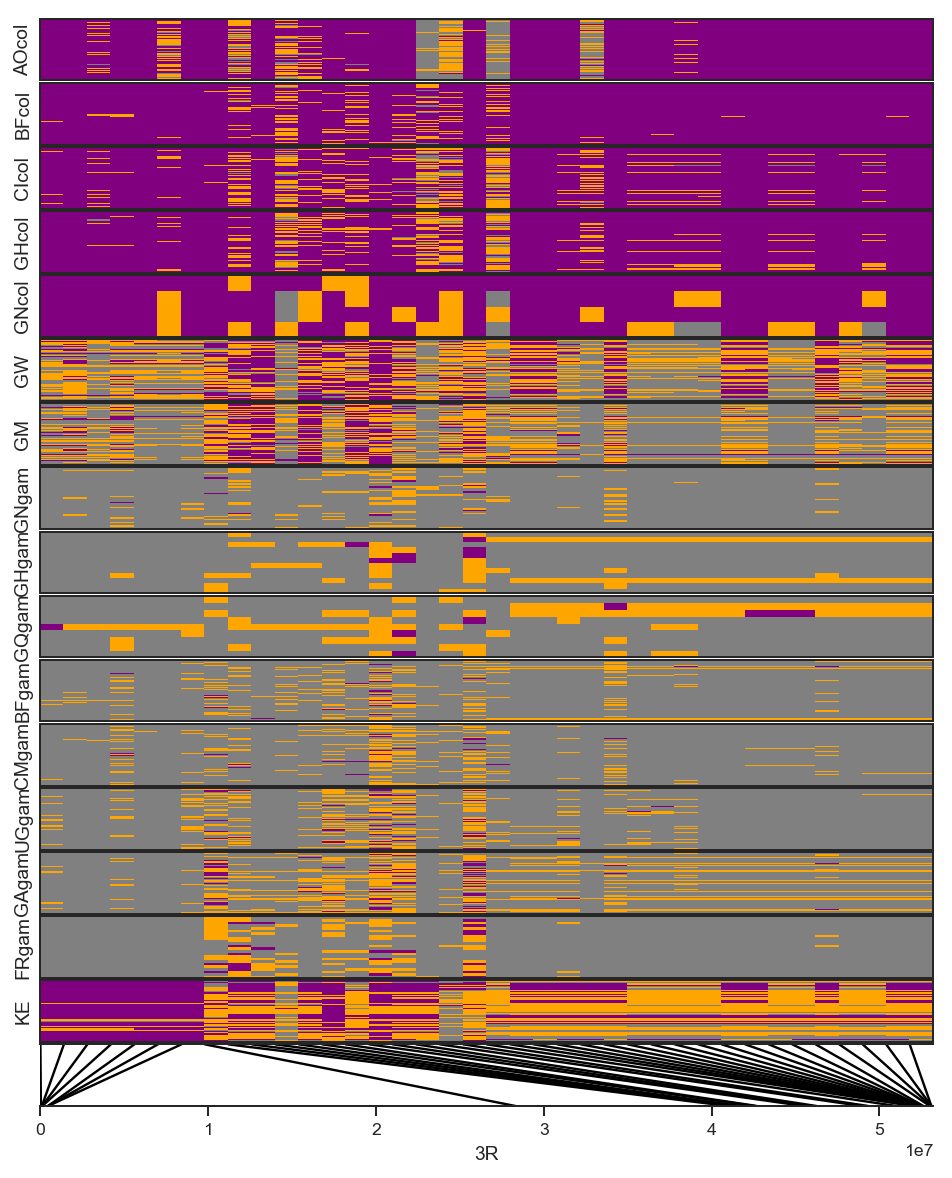

In [31]:
chrom_aim('3R')

In [32]:
gen_dict = {
    'gam/gam': 'b',
    'col/col': 'r',
    'hybrid' : 'y',
    'missing': 'k'
}

In [33]:
def all_aim():

    fig = plt.figure(figsize=(16,8))

    # define subplot layout
    gs_nrows = 17
    gs_ncols = 5
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.08, wspace=0.04, height_ratios=[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                              width_ratios=[1,1,1,1,1])

    
    blah = 0
    for chrom in '2R', '2L', '3R', '3L', 'X':
        gn_aim, pos_isec = compute_aim_gn(chrom)
        for p in list(counter.keys()):
            grr = gn_aim.take(subpops[p], axis=1)
            grr = np.rot90(grr)
            ax = fig.add_subplot(gs[counter[p], blah])


            cMap = c.ListedColormap(['gray',  'orange', 'purple'])
            ax.pcolormesh(grr, cmap = cMap)
            y_max = grr.shape[0]
            ax.set_ylim(0, y_max)
            x_max = grr.shape[1]
            ax.set_xlim(0, x_max)
            ax.set_xticks([])
            ax.set_yticks([])
            if chrom == '2R':
                ax.set_ylabel(p, rotation='horizontal')
                ax.yaxis.labelpad = 17

        ax = fig.add_subplot(gs[16, blah])
        stop = chrom_len[chrom] + 1
        allel.plot_variant_locator(pos_isec, ax=ax, step=1, start=0, stop=stop, line_kwargs=dict(color='k'))
        plt.xlabel(chrom, labelpad=8)
        blah += 1
        
#     handles = [mpl.patches.Patch(color=['purple', 'gray',  'orange'], label=gen) for gen in ['col/col', 'gam/gam',  'hybrid']]
#     plt.legend(handles=handles, bbox_to_anchor= (1.4, 18.4), title='AIM genotype')    
#     fig.savefig('phase_2_AIM_plot.jpg', jpeg_quality=100, dpi=300, bbox_inches='tight')

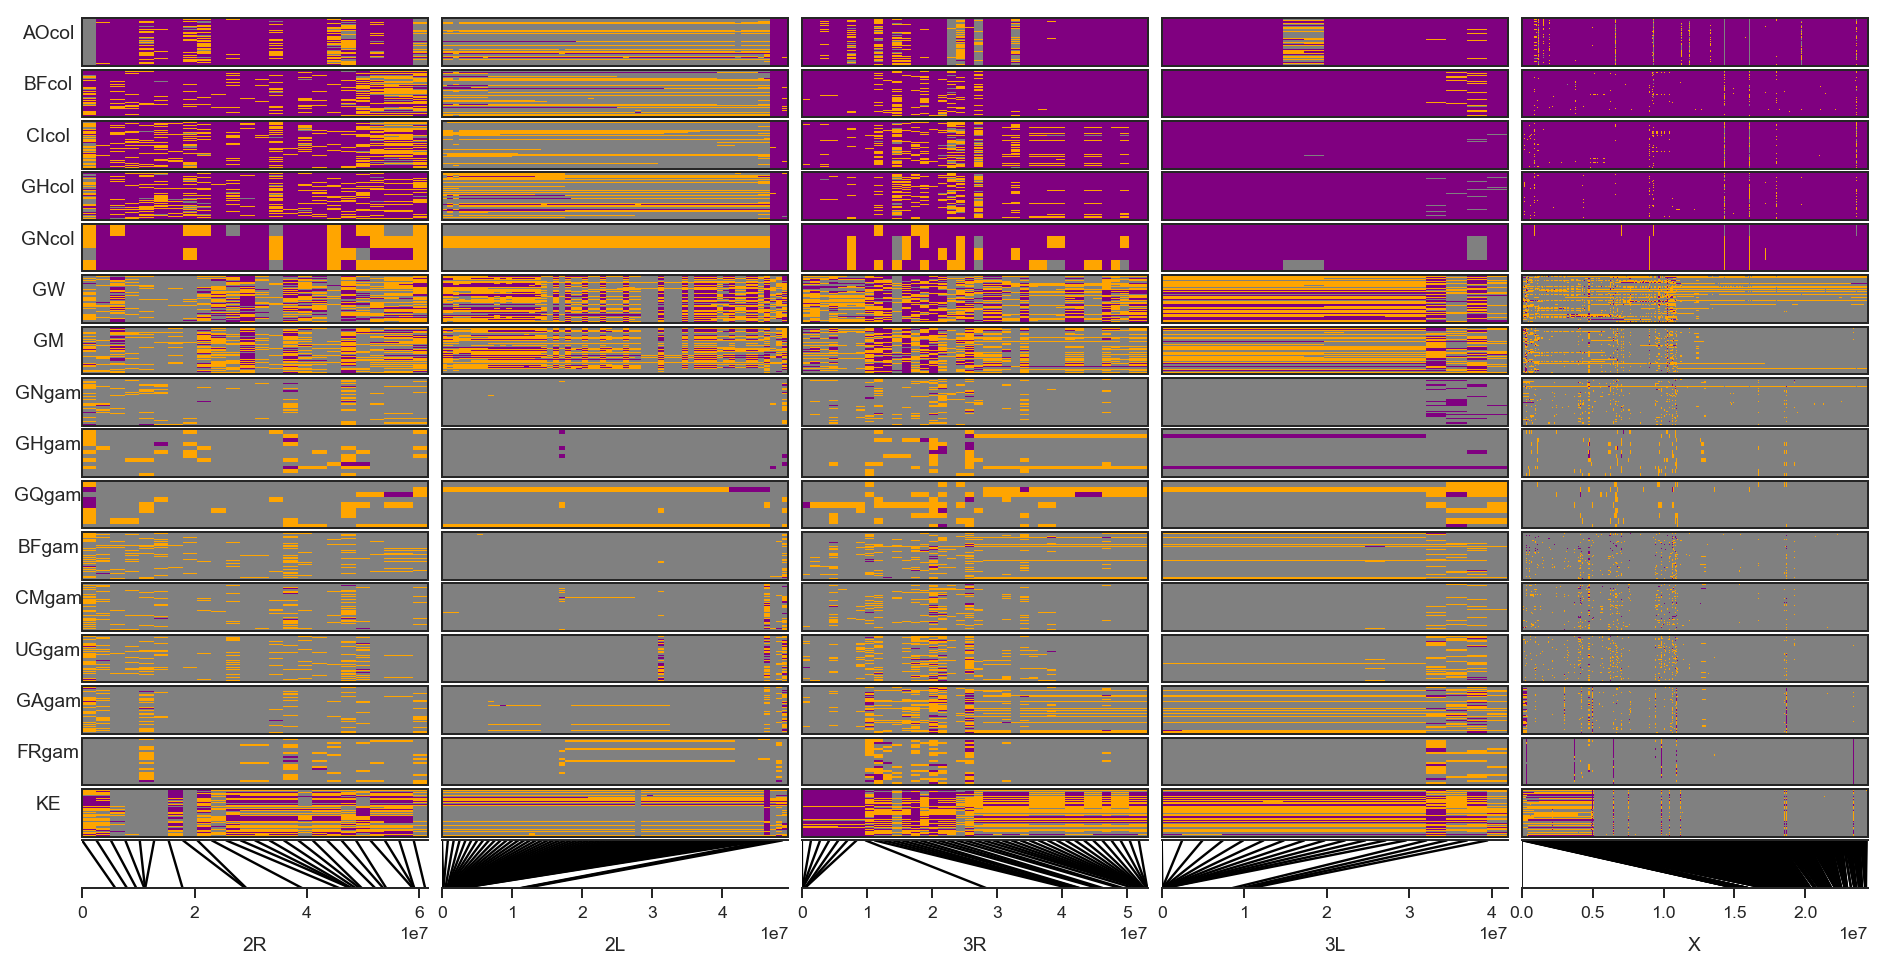

In [34]:
all_aim()

In [35]:
#Add a meta data species column, a kdr genotype column, scale pop by size and change colour back to blue/red/yellow

# add species column

In [135]:
#meta data species - switch to pandas from etl
sp_fn = '../phase2.AR1/samples/samples.species.txt'
df_sp = pd.read_csv(sp_fn, sep='\t')
df_sp = df_sp.fillna('')
df_sp.meta = df_sp.meta.astype(str)

In [144]:
#make Guinea Bissau great again
gw = df_sp.ox_code.str.contains('AJ', regex=False)
df_sp.loc[df_sp.ox_code.str.contains('AJ'), 'meta'] = ''

In [145]:
df_sp = df_sp.replace({'S' : 0, 'M' : 1, 'M/S' : 2, '' : 3})
df_sp.meta = df_sp.meta.astype(int)

In [146]:
metar = df_sp.meta.values.reshape((1142, 1))

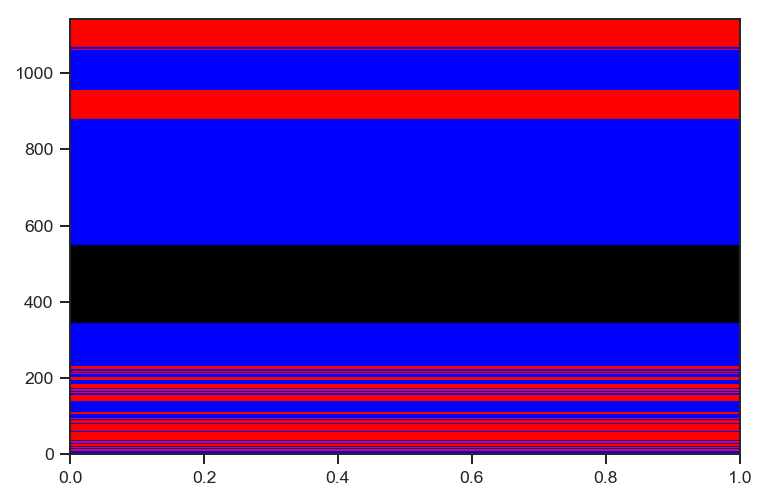

In [147]:
plt.pcolormesh(metar, cmap=c.ListedColormap(['b', 'r', 'y', 'k']) )

In [149]:
def all_aim_sp():

    fig = plt.figure(figsize=(16,8))

    # define subplot layout
    gs_nrows = 17
    gs_ncols = 6
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.08, wspace=0.04, height_ratios=[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                              width_ratios=[0.1,1,1,1,1,1])

    
    blah = 1
    for chrom in 'sp','X', '2R', '2L', '3R', '3L':
        if chrom == 'sp':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], 0])
                a = metar.take(subpops[p], axis=0)
                ax.pcolormesh(a, vmin = 0, vmax = 3, cmap=c.ListedColormap(['b', 'r', 'y', 'k']) )
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel(p, rotation='horizontal')
                ax.yaxis.labelpad = 17
                if p == 'AOcol':
                    ax.set_title('Sp.')
        
        if chrom != 'sp':    
            gn_aim, pos_isec = compute_aim_gn(chrom)
            for p in list(counter.keys()):
                grr = gn_aim.take(subpops[p], axis=1)
                grr = np.rot90(grr)
                ax = fig.add_subplot(gs[counter[p], blah])


                #cMap = c.ListedColormap(['gray',  'orange', 'purple'])
                cMap = c.ListedColormap(['b', 'k', 'y', 'r'])
                ax.pcolormesh(grr, cmap = cMap)
                y_max = grr.shape[0]
                ax.set_ylim(0, y_max)
                x_max = grr.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title(chrom)


            ax = fig.add_subplot(gs[16, blah])
            stop = chrom_len[chrom] + 1
            allel.plot_variant_locator(pos_isec, ax=ax, step=1, start=0, stop=stop, line_kwargs=dict(color='k'))
            #plt.xlabel(chrom, labelpad=8)
            blah += 1
        
    handles = [mpl.patches.Patch(color=gen_dict[gen], label=gen) for gen in ['col/col', 'gam/gam',  'hybrid', 'missing']]
    plt.legend(handles=handles, bbox_to_anchor= (1.4, 18.4), title='AIM genotype')
    
#     fig.savefig('phase_2_AIM_plot.jpg', jpeg_quality=100, dpi=300, bbox_inches='tight')
        

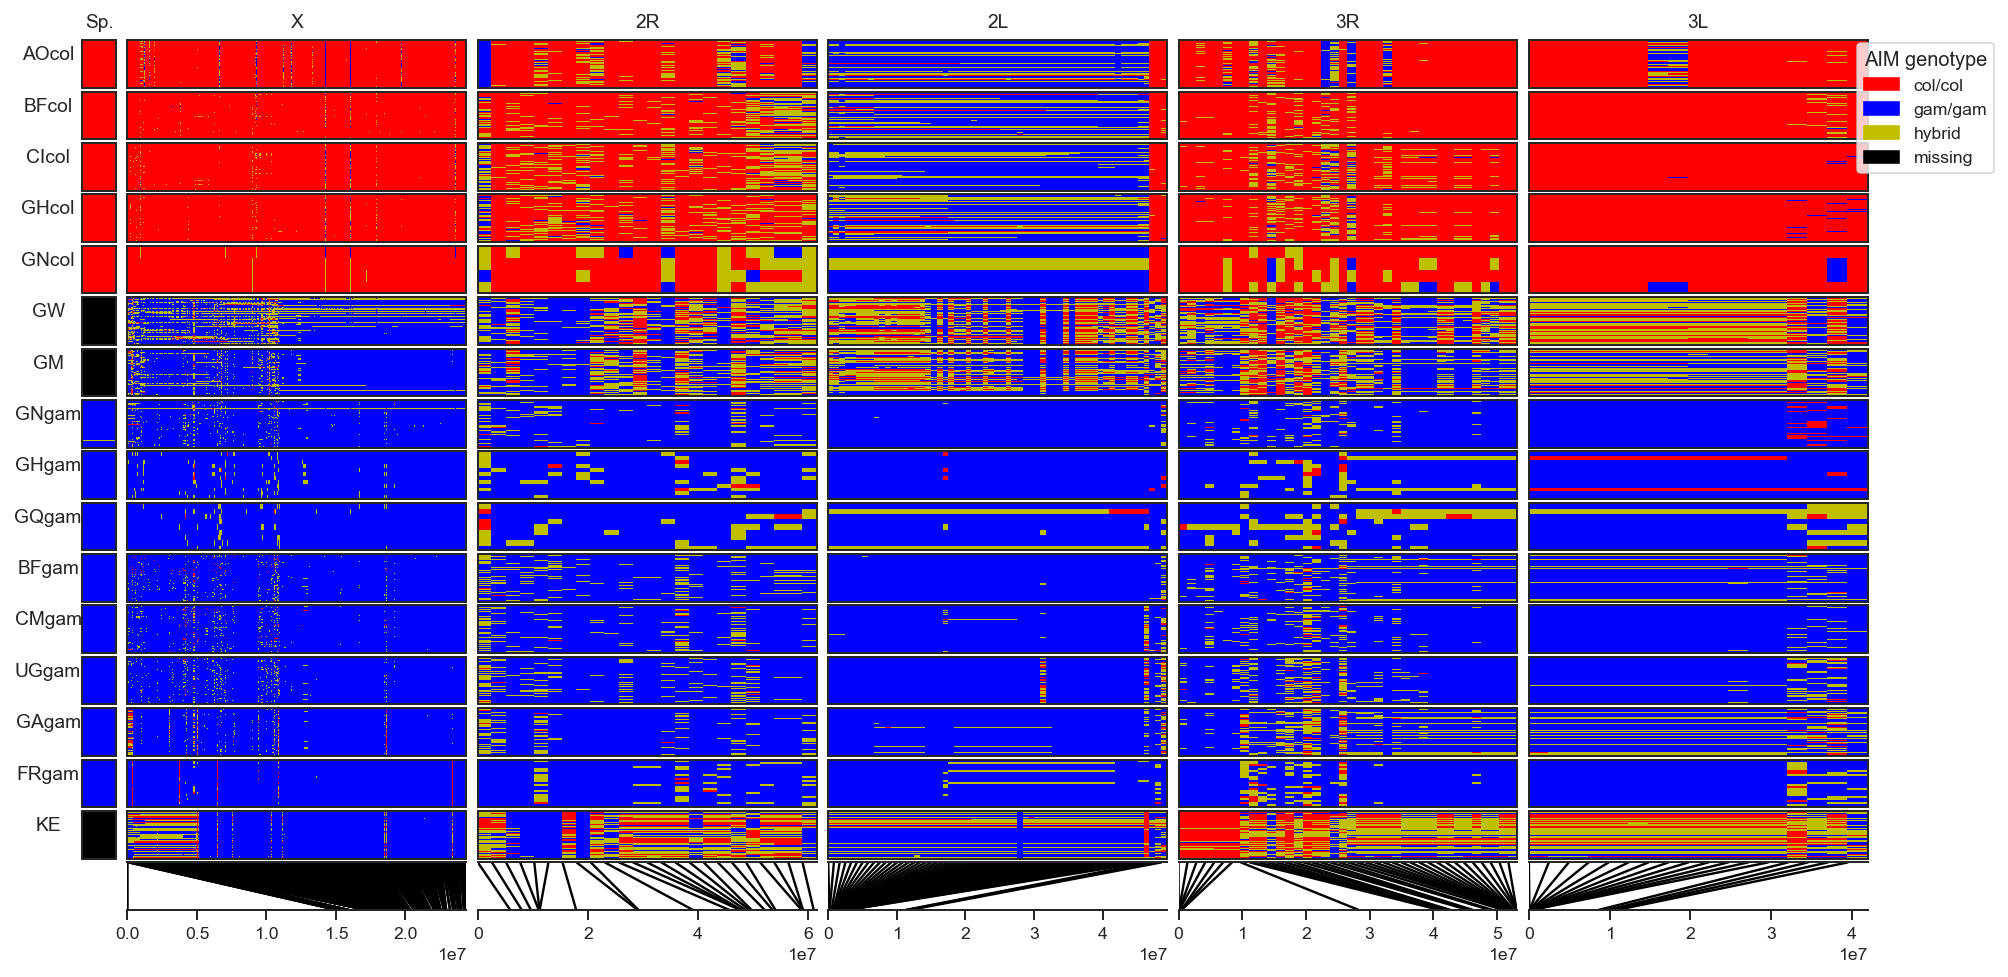

In [150]:
all_aim_sp()

# add kdr column

In [151]:
#meta data species
kdr_fn = '../phase2.AR1/samples/samples.kdr.txt'
tbl_kdr = etl.fromtsv(kdr_fn).convertall({'+/+' : 0, '+/F' : 1, 'F/F' : 2, '+/S' : 3, 'S/S' : 4, 'F/S' : 5})
tbl_kdr

0|ox_code,1|vgsc_995
AA0040-C,2
AA0041-C,2
AA0042-C,2
AA0043-C,1
AA0044-C,1


In [152]:
kdr_dict = {
    '+/+': 'c', 
    '+/F': 'm',
    'F/F': 'g',    
    '+/S': 'gray',
    'S/S': 'chartreuse',    
    'F/S': 'burlywood'
}

In [153]:
#grab column
kdr_tbl = tbl_kdr.cut('vgsc_995')
#needs to be in np array it would appear for colourmesh to work
kdar = np.array(kdr_tbl.data())
kdar.shape

(1142, 1)

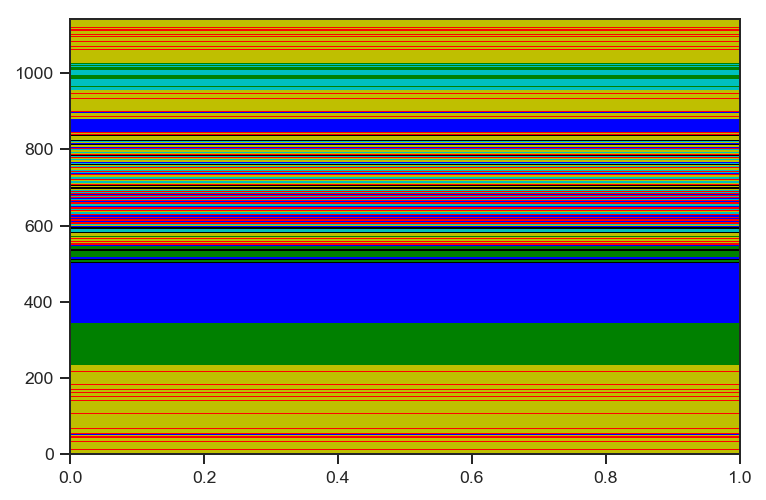

In [154]:
plt.pcolormesh(kdar, cmap=c.ListedColormap(['b', 'r', 'y', 'k', 'g', 'c']) )

In [155]:
def all_aim_kdr():

    fig = plt.figure(figsize=(16,8))

    # define subplot layout
    gs_nrows = 17
    gs_ncols = 7
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.08, wspace=0.04, height_ratios=[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                              width_ratios=[0.1,1,1,1,1,1,0.1])

    
    blah = 1
    for chrom in 'sp','X', '3R', '3L', '2R', '2L', 'kdr':
        if chrom == 'sp':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], 0])
                a = metar.take(subpops[p], axis=0)
                ax.pcolormesh(a, vmin = 0, vmax = 3, cmap=c.ListedColormap(['b', 'r', 'y', 'k']) )
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel(p, rotation='horizontal')
                ax.yaxis.labelpad = 17
                if p == 'AOcol':
                    ax.set_title('sp.')
        
        if chrom != 'sp' and chrom != 'kdr':    
            gn_aim, pos_isec = compute_aim_gn(chrom)
            for p in list(counter.keys()):
                grr = gn_aim.take(subpops[p], axis=1)
                grr = np.rot90(grr)
                ax = fig.add_subplot(gs[counter[p], blah])


                #cMap = c.ListedColormap(['gray',  'orange', 'purple'])
                cMap = c.ListedColormap(['b', 'k', 'y', 'r'])
                ax.pcolormesh(grr, cmap = cMap)
                y_max = grr.shape[0]
                ax.set_ylim(0, y_max)
                x_max = grr.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title(chrom)


            ax = fig.add_subplot(gs[16, blah])
            stop = chrom_len[chrom] + 1
            allel.plot_variant_locator(pos_isec, ax=ax, step=1, start=0, stop=stop, line_kwargs=dict(color='k'))
            #plt.xlabel(chrom, labelpad=8)
            blah += 1
            
        if chrom == 'kdr':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], blah])
                a = kdar.take(subpops[p], axis=0)
                ax.pcolormesh(a, vmin = 0, vmax = 5, cmap=c.ListedColormap(['c', 'm', 'g', 'gray', 'chartreuse','burlywood']))
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title('995')
        
    handles1 = [mpl.patches.Patch(color=gen_dict[gen], label=gen) for gen in ['col/col', 'gam/gam',  'hybrid', 'missing']]
    #plt.legend(handles=handles1, bbox_to_anchor= (5.2, 17.95), title='AIM genotype')
    plt.gca().add_artist(plt.legend(handles=handles1, bbox_to_anchor= (5.4, 17.95), title='AIM genotype'))
    handles2 = [mpl.patches.Patch(color=kdr_dict[gen], label=gen) for gen in ['+/+', '+/F', 'F/F', '+/S', 'S/S', 'F/S' ]]
    plt.legend(handles=handles2, bbox_to_anchor= (4.6, 14.95), title='995 genotype')   
    
    
#     fig.savefig('phase_2_AIM_plot.jpg', jpeg_quality=100, dpi=300, bbox_inches='tight')
          

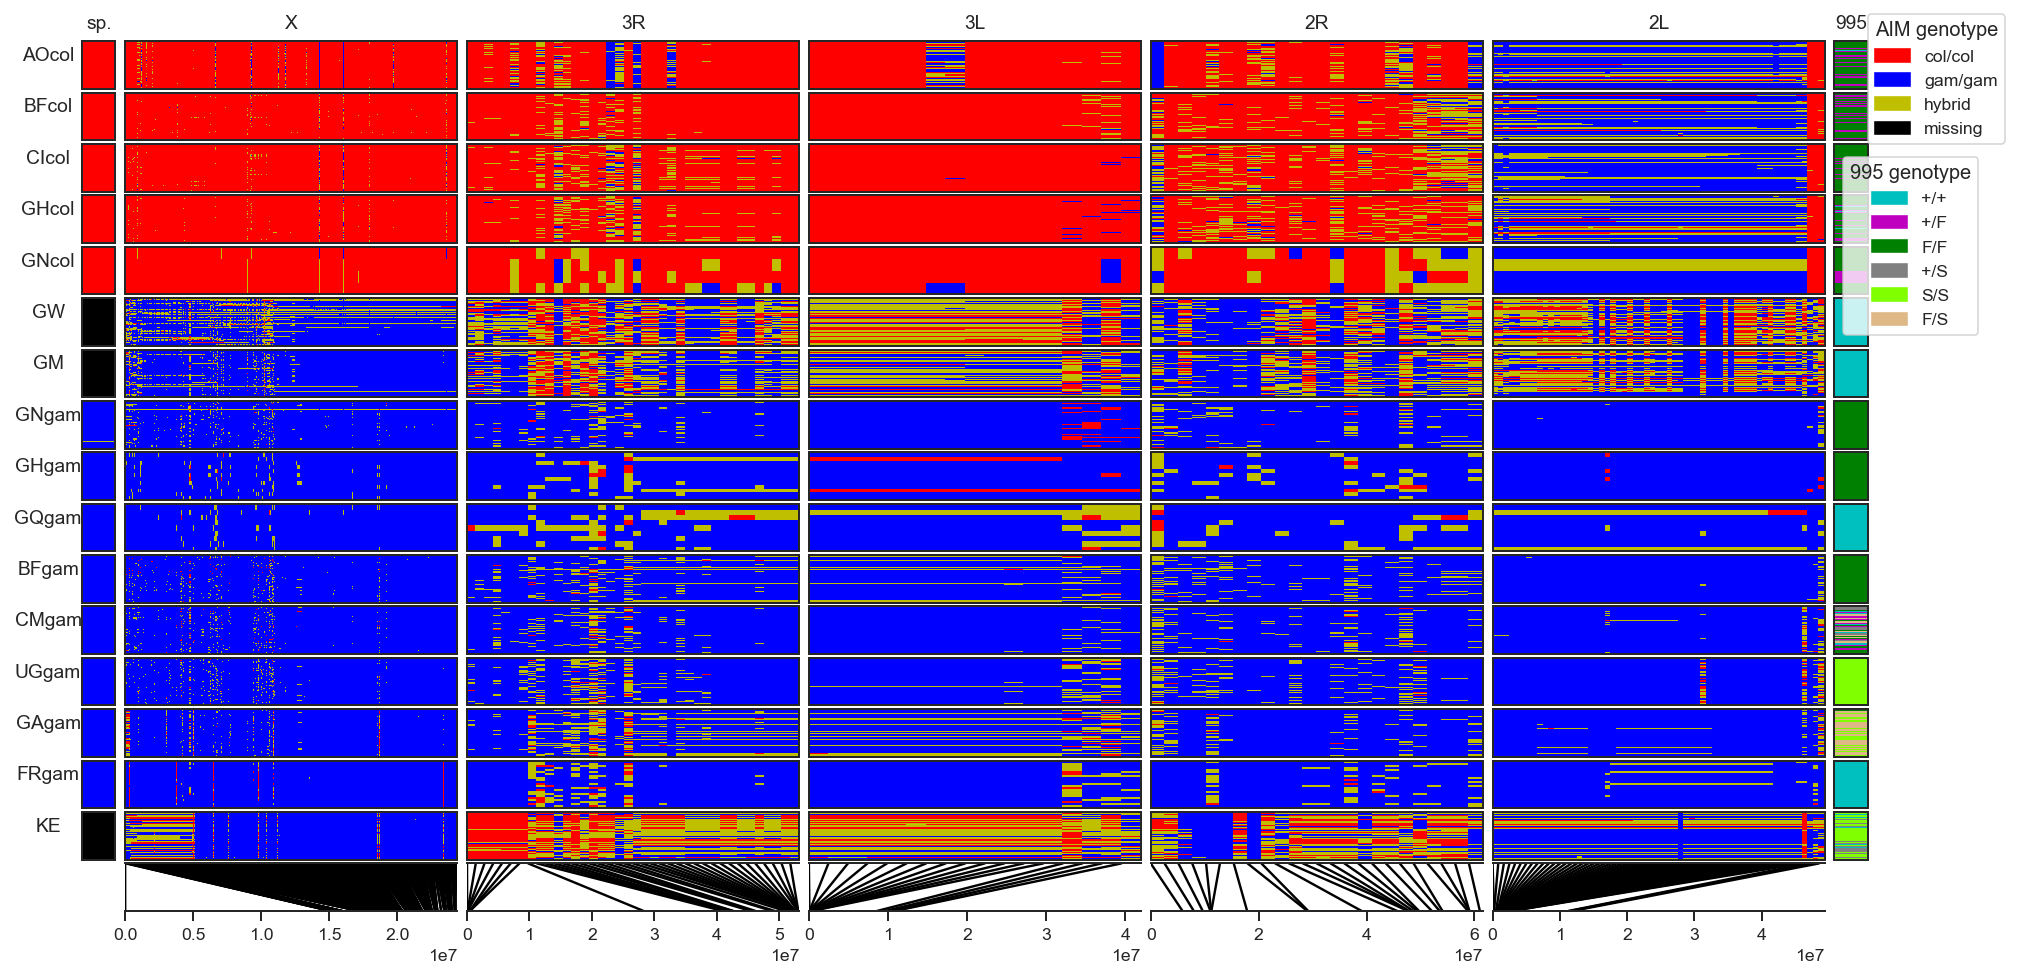

In [156]:
all_aim_kdr()

# sp column is reversed relative to chrom, but rather than fix this, calculate % gambiae and sort each pop so that most gambiae is at top

- extract sample genotypes (X)
- extract sample % (Y)
- ind = np.argsort(X)
- Ysort = np.take(Y, ind)

## Remember to produce a second plot scaled by pop_size

In [157]:
#first calculate the genome % gambiae for each sample in each population

In [158]:
#low numbers = gambiae, high = coluzzii
#make an 1142 array of zeros then add each chromo for each indiv
totes_col = np.zeros(1142)
for chrom in 'X', '3R', '3L', '2R', '2L':
    gn_aim, pos_isec = compute_aim_gn(chrom)
    for ind in range(1142):
        totes_col[ind] += gn_aim[:,ind].sum()
    log(chrom, totes_col[:10])

X [687. 689. 686. 684. 687.  12. 682.   3. 689. 686.]
3R [762. 760. 759. 754. 758.  14. 749.  24. 759. 754.]
3L [796. 794. 793. 788. 792.  14. 782.  37. 792. 788.]
2R [837. 837. 837. 830. 836.  18. 825.  39. 835. 830.]
2L [864. 864. 843. 890. 913.  19. 885.  39. 862. 892.]


In [159]:
totes_col.shape

(1142,)

In [191]:
def all_aim_sort():

    fig = plt.figure(figsize=(16,8))

    # define subplot layout
    gs_nrows = 17
    gs_ncols = 7
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.08, wspace=0.04, height_ratios=[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                              width_ratios=[0.1,1,1,1,1,1,0.1])

    
    blah = 1
    for chrom in 'sp','X', '3R', '3L', '2R', '2L', 'kdr':
        if chrom == 'sp':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], 0])
                a = metar.take(subpops[p], axis=0)
                #sort by amount gambiae
                b = totes_col.take(subpops[p])
                ind = np.argsort(b)[::-1]
                a = np.take(a, ind, axis=0)
                #plot
                ax.pcolormesh(a, vmin = 0, vmax = 3, cmap=c.ListedColormap(['b', 'r', 'y', 'k']) )
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel(p, rotation='horizontal')
                ax.yaxis.labelpad = 17
                if p == 'AOcol':
                    ax.set_title('sp.')
        
        if chrom != 'sp' and chrom != 'kdr':    
            gn_aim, pos_isec = compute_aim_gn(chrom)
            for p in list(counter.keys()):
                grr = gn_aim.take(subpops[p], axis=1)[:] #needs to be array'ed

                grr = grr.T  #transpose - not rotate!
                                
                b = totes_col.take(subpops[p])
                ind = np.argsort(b)[::-1]
                grr = np.take(grr, ind, axis=0)
                
                ax = fig.add_subplot(gs[counter[p], blah])
                #cMap = c.ListedColormap(['gray',  'orange', 'purple'])
                cMap = c.ListedColormap(['b', 'k', 'y', 'r'])
                ax.pcolormesh(grr, cmap = cMap)
                y_max = grr.shape[0]
                ax.set_ylim(0, y_max)
                x_max = grr.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title(chrom)


            ax = fig.add_subplot(gs[16, blah])
            stop = chrom_len[chrom] + 1
            allel.plot_variant_locator(pos_isec, ax=ax, step=1, start=0, stop=stop, line_kwargs=dict(color='k'))
            #plt.xlabel(chrom, labelpad=8)
            blah += 1
            
        if chrom == 'kdr':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], blah])
                a = kdar.take(subpops[p], axis=0)
                #sort by amount gambiae
                b = totes_col.take(subpops[p])
                ind = np.argsort(b)[::-1]
                a = np.take(a, ind, axis=0)
                #plot
                ax.pcolormesh(a, vmin = 0, vmax = 5, cmap=c.ListedColormap(['c', 'm', 'g', 'gray', 'chartreuse','burlywood']))
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title('995')
        
    handles1 = [mpl.patches.Patch(color=gen_dict[gen], label=gen) for gen in ['col/col', 'gam/gam',  'hybrid', 'missing']]
    #plt.legend(handles=handles1, bbox_to_anchor= (5.2, 17.95), title='AIM genotype')
    plt.gca().add_artist(plt.legend(handles=handles1, bbox_to_anchor= (6.9, 17.5), title='AIM genotype       ', frameon=False))
    handles2 = [mpl.patches.Patch(color=kdr_dict[gen], label=gen) for gen in ['+/+', '+/F', 'F/F', '+/S', 'S/S', 'F/S' ]]
    plt.legend(handles=handles2, bbox_to_anchor= (5.6, 14.5), title='995 genotype', frameon=False)   
    
    
    fig.savefig('../artwork/AIM_figure.jpg', jpeg_quality=100, dpi=300, bbox_inches='tight')

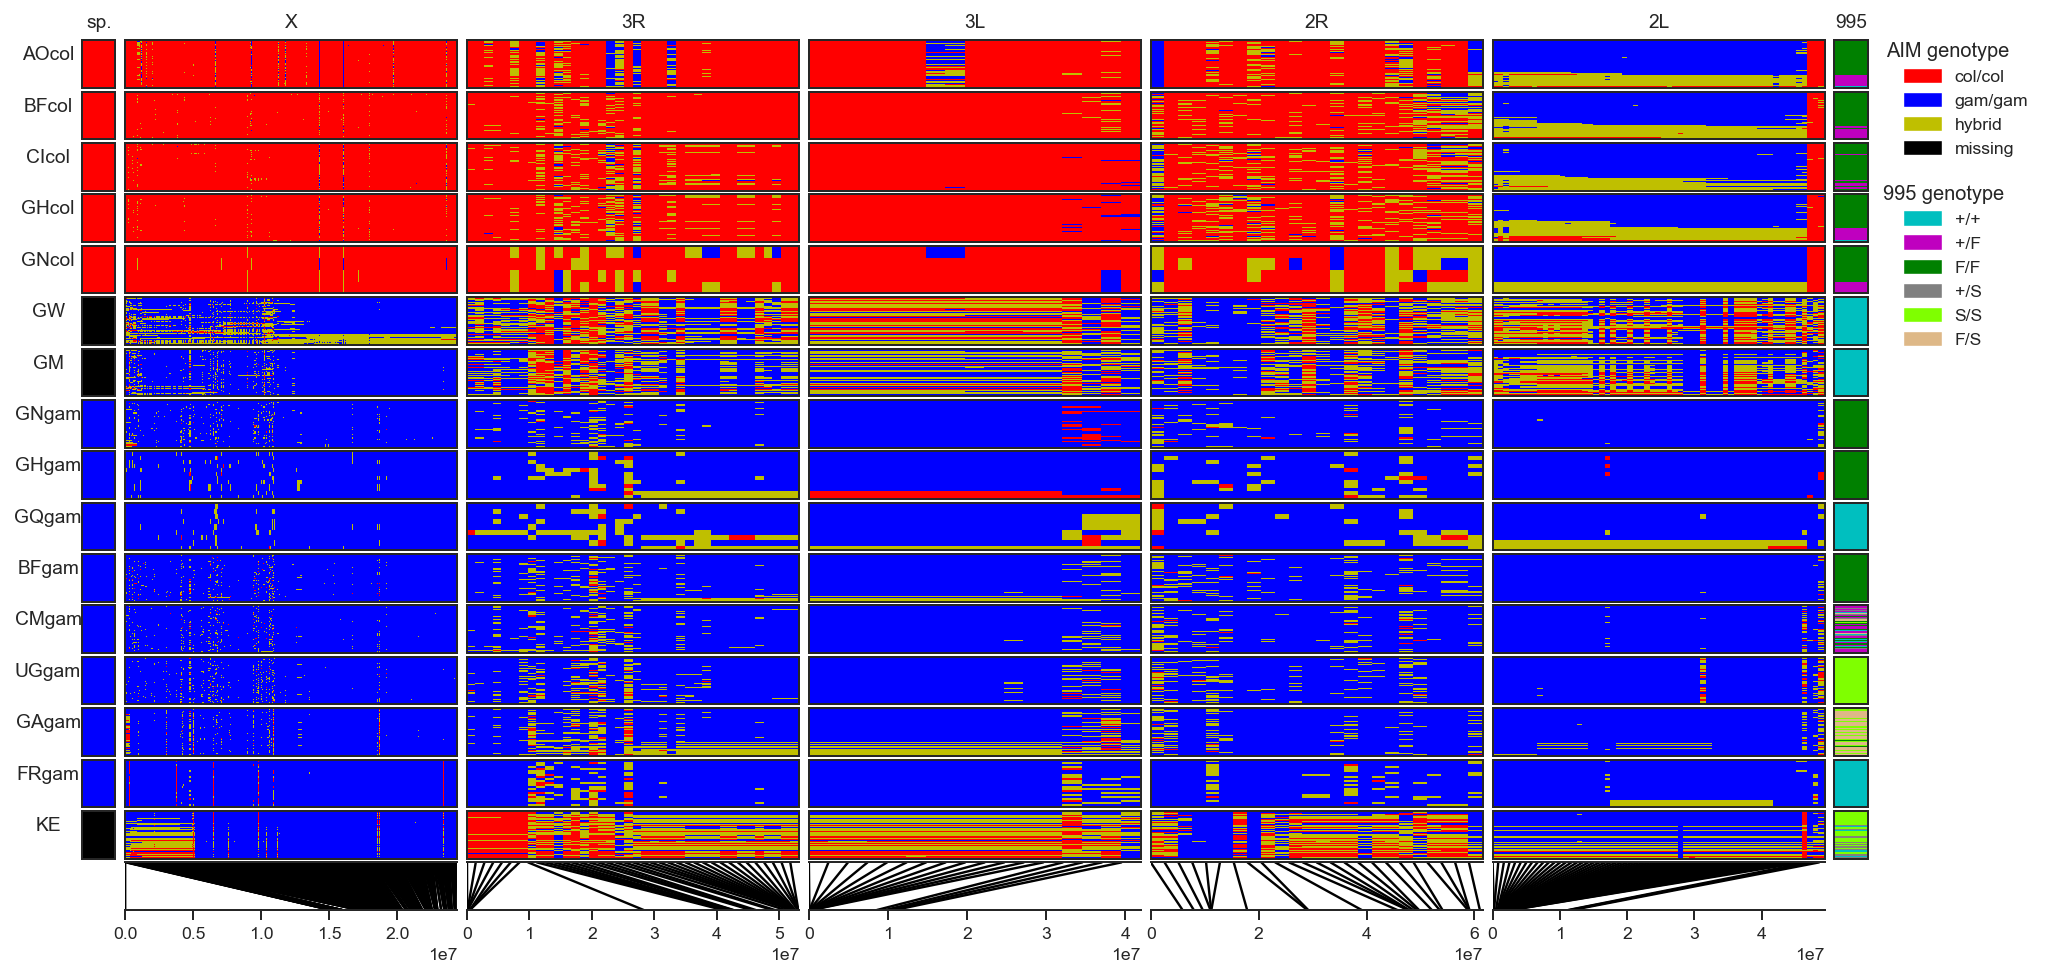

In [192]:
all_aim_sort()

# scale row to pop size

In [177]:
#as a fraction of 1142 get height ratios for gridspec..
hu = []
for p in list(counter.keys()):
    hu.append(np.log((gn_aim.take(subpops[p], axis=1)).shape[1]/1142*100)+2)
# hu.append(6.66)
hu.append(5)

In [178]:
hu

[3.9213426224617276,
 3.882121909308446,
 3.8273136728134514,
 3.5719669810046066,
 0.9509281568920265,
 4.0754933022889865,
 3.7390210656677727,
 3.253513249886072,
 2.0495404455601363,
 1.7618583731083552,
 4.0864223728211755,
 5.258365934574835,
 4.28313266706723,
 3.798740300369395,
 2.742687626120081,
 3.4358348066800266,
 5]

In [195]:
def all_aim_scale():

    fig = plt.figure(figsize=(16,8))

    # define subplot layout
    gs_nrows = 17
    gs_ncols = 7
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.08, wspace=0.04, height_ratios=hu,
                              width_ratios=[0.1,1,1,1,1,1,0.1])

    
    blah = 1
    for chrom in 'sp','X', '3R', '3L', '2R', '2L', 'kdr':
        if chrom == 'sp':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], 0])
                a = metar.take(subpops[p], axis=0)
                #sort by amount gambiae
                b = totes_col.take(subpops[p])
                ind = np.argsort(b)[::-1]
                a = np.take(a, ind, axis=0)
                #plot
                ax.pcolormesh(a, vmin = 0, vmax = 3, cmap=c.ListedColormap(['b', 'r', 'y', 'k']) )
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel(p, rotation='horizontal')
                ax.yaxis.labelpad = 17
                if p == 'AOcol':
                    ax.set_title('sp.')
        
        if chrom != 'sp' and chrom != 'kdr':    
            gn_aim, pos_isec = compute_aim_gn(chrom)
            for p in list(counter.keys()):
                grr = gn_aim.take(subpops[p], axis=1)[:] #needs to be array'ed

                grr = grr.T  #transpose - not rotate!
                                
                b = totes_col.take(subpops[p])
                ind = np.argsort(b)[::-1]
                grr = np.take(grr, ind, axis=0)
                
                ax = fig.add_subplot(gs[counter[p], blah])
                #cMap = c.ListedColormap(['gray',  'orange', 'purple'])
                cMap = c.ListedColormap(['b', 'k', 'y', 'r'])
                ax.pcolormesh(grr, cmap = cMap)
                y_max = grr.shape[0]
                ax.set_ylim(0, y_max)
                x_max = grr.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title(chrom)


            ax = fig.add_subplot(gs[16, blah])
            stop = chrom_len[chrom] + 1
            allel.plot_variant_locator(pos_isec, ax=ax, step=1, start=0, stop=stop, line_kwargs=dict(color='k'))
            #plt.xlabel(chrom, labelpad=8)
            blah += 1
            
        if chrom == 'kdr':
            for p in list(counter.keys()):
                ax = fig.add_subplot(gs[counter[p], blah])
                a = kdar.take(subpops[p], axis=0)
                #sort by amount gambiae
                b = totes_col.take(subpops[p])
                ind = np.argsort(b)[::-1]
                a = np.take(a, ind, axis=0)
                #plot
                ax.pcolormesh(a, vmin = 0, vmax = 5, cmap=c.ListedColormap(['c', 'm', 'g', 'gray', 'chartreuse','burlywood']))
                y_max = a.shape[0]
                ax.set_ylim(0, y_max)
                x_max = a.shape[1]
                ax.set_xlim(0, x_max)
                ax.set_xticks([])
                ax.set_yticks([])
                if p == 'AOcol':
                    ax.set_title('995')
        
    handles1 = [mpl.patches.Patch(color=gen_dict[gen], label=gen) for gen in ['col/col', 'gam/gam',  'hybrid', 'missing']]
    #plt.legend(handles=handles1, bbox_to_anchor= (5.2, 17.95), title='AIM genotype')
    plt.gca().add_artist(plt.legend(handles=handles1, bbox_to_anchor= (6.9, 17.5), title='AIM genotype       ', frameon=False))
    handles2 = [mpl.patches.Patch(color=kdr_dict[gen], label=gen) for gen in ['+/+', '+/F', 'F/F', '+/S', 'S/S', 'F/S' ]]
    plt.legend(handles=handles2, bbox_to_anchor= (5.6, 14.5), title='995 genotype', frameon=False)   
    
    
    fig.savefig('../artwork/AIM_figure_scaled.jpg', jpeg_quality=100, dpi=300, bbox_inches='tight')

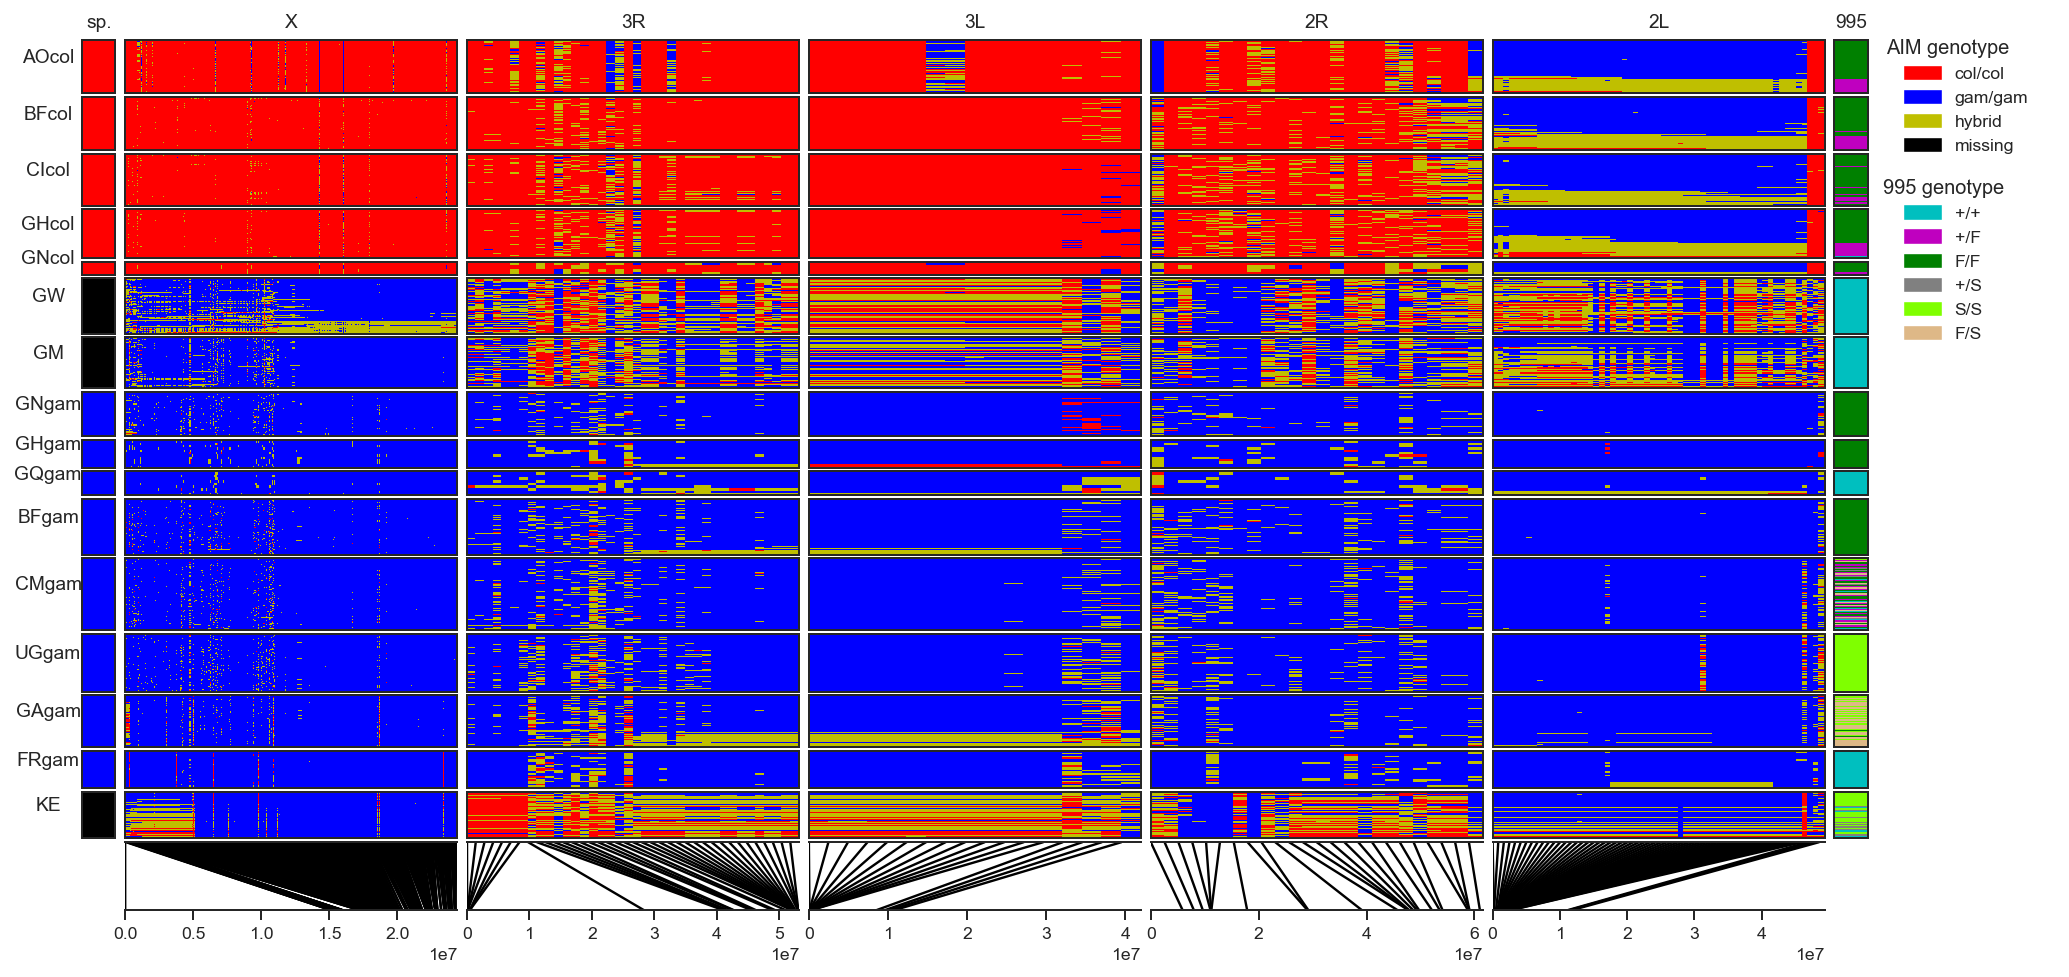

In [196]:
all_aim_scale()